# Two Dimensional Verification Example

In this notebook, we use the `Network` and `Layer` API of NeuralVerification.jl to construct a neural network that maps two dimensional inputs to two dimensional outputs. We demonstrate how to define and verify a property on this network, and plot the output of the network at interesting moments throughout the problem.

In [73]:
using NeuralVerification, LazySets, LinearAlgebra
# We also import several functions and types so we can 
# avoid e.g. the verbose NeuralVerification.ReLU(), etc.
import NeuralVerification: Network, Layer, ReLU, Id, affine_map, forward_partition

# Set up some plotting stuff for later.
using Plots, LaTeXStrings
default(size = (300,300), legend = :none)
function Plots.plot(V::Vector{<:AbstractPolytope}, args...)
    p = plot()
    for s in V
        plot!(p, s, args...)
    end
    return p
end

### Layers

Let's begin by constructing our network. A layer is defined by a set of weights $\mathbf{W}$, a bias, $\mathbf{b}$, and a nonlinear activation function, usually denoted $\sigma$.
Here we define the input layer $L_1$ to be a ReLU layer expecting a 2D input. 

In [74]:
W = [1.0 0.5;
     0.5 1.0]

b = [0, -0.5]

L₁ = Layer(W, b, ReLU())

Layer{ReLU,Float64}([1.0 0.5; 0.5 1.0], [0.0, -0.5], ReLU())

We can apply our layer to an input $x$ by performing $\sigma (Wx + b)$

In [102]:
let x = [2,-1], σ = L₁.activation
    
    ẑ = affine_map(L₁, x) # affine_map performs W*x + b
    z = σ(ẑ)

    println("x: $x ⟶ ẑ: $ẑ ⟶ z: $z")
end

x: [2, -1] ⟶ ẑ: [1.5, -0.5] ⟶ z: [1.5, 0.0]


### Networks 

A Network consists of a vector of these layers. Here we construct a network using $L_1$ and 6 more layers. The layers were initally created with random weights and biases, and then hard-coded here for repeatability. Note that the last layer is an identity layer.

In [76]:
layers = [
        L₁,
        Layer([1.14327 0.1497; 0.0938726 1.02164], [0.427767, -0.441637], ReLU()),   
        Layer([1.03721 0.083906; 0.174684 1.13746], [-0.664744, 0.4121], ReLU()),    
        Layer([1.07418 0.155875; 0.147354 1.09946], [-1.20265, -0.566685], ReLU()),  
        Layer([1.08786 0.159884; 0.0990573 1.00572], [-0.559988, -0.301343], ReLU()),
        Layer([1.18447 0.177153; 0.00392835 1.18098], [0.422727, 1.04569], ReLU()),
        Layer([1.14041 0.182869; 0.186956 1.18623], [1.51287, 0.497855], Id()),
        ]

net = Network(layers);

### Sets

Now we can consider an input/output property of interest. Normally, the inputs an outputs of the network would have some semantic meaning (controls, labels, etc.) which would inform these properties. In this case, since we don't have anything like that, we will choose our input and output sets to be two arbitrary hyperrectangles.

$X = \left\{ x_1, x_2 \mid  0 \leq x_i \leq 1     \right\}$

$Y = \left\{ y_1, y_2 \mid  2 \leq y_i \leq 4     \right\}$

The verification problem consists of determining whether $f(X) \subseteq Y$. Note that not all algorithms support all types of sets. The documentation contains a [table](https://sisl.github.io/NeuralVerification.jl/latest/problem/) listing input and output sets by algorithm.

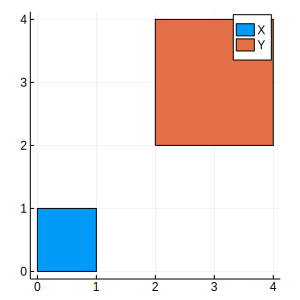

In [77]:
X = Hyperrectangle(low = [0, 0], high = [1, 1])
Y = Hyperrectangle(low = [2, 2], high = [4, 4]);

plot(X, label = "X", legend = true)
plot!(Y, label = "Y")

### Reachability

We can transform the input set according to each layer by applying the same transformation introduced earlier. However, the nonlinearity in the ReLU requires that the set be partitioned along the $x=0$ and $y=0$ axes and that each subset is treated independently. If the subset lies in the positive quadrant, it is unchanged. In the negative quadrants, the ReLU operation projects the set onto the axis (by setting the negative componets of points in the set to $0$).

This is demonstrated in the cell below. We transform the set $X$ subject to $L_1$ (we use `affine_map` again as before, but this time must call `forward_partition` to perform the ReLU on a set).

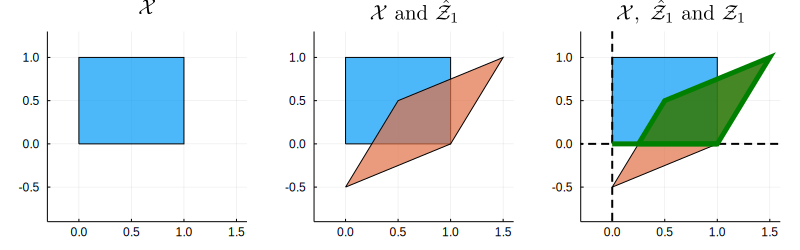

In [68]:
Ẑ = affine_map(L₁, X)
Z = forward_partition(L₁.activation, Ẑ)


#### Just plotting stuff:
t1 = L"\mathcal{X}"
t2 = L"\mathcal{X} \mathrm{\ and\ } \hat{\mathcal{Z}}_1"
t3 = L"\mathcal{X},\ \hat{\mathcal{Z}}_1 \mathrm{\ and\ } \mathcal{Z}_1"

p1 = plot(X, fill = 0.7, xlim = (-0.3, 1.6), ylim = (-0.9 ,1.3), title = t1)

p2 = deepcopy(p1)
plot!(p2, Ẑ, fill = 0.7, title = t2)

p3 = deepcopy(p2)
hline!(p3, [0], line = (2, :black, :dash), fill = 0.7)
vline!(p3, [0], line = (2, :black, :dash), fill = 0.7)
plot!(p3, Z, line = (:green, 5), fill = (:green, 0.7), title = t3)

plot(p1, p2, p3, size = (800, 250), layout = (1,3))

### Solving a Problem

Now that the network and property are both defined, we can construct a `Problem` object out of them. We use `ExactReach` to verify the property, which employs exact reachability techniques to calculate the true output set $f(X)$ and compare it to the desired output set $Y$. Since our network is small and simple, we can afford to do this, but in general, exact reachability is a computationaly expensive approach that scales poorly.


### ExactReach

In [78]:
prob = Problem(net, X, Y)
res = solve(ExactReach(), prob)

# check the result
res.status

:violated

We find that the property is violated. The full printout of `res` is avoided above because, in the case of a violated input-output relation, ExactReach returns the computed output set, which is quite long in this case. We plot the output set, as well as $\mathcal Y$ below, to understand why the property does not hold.

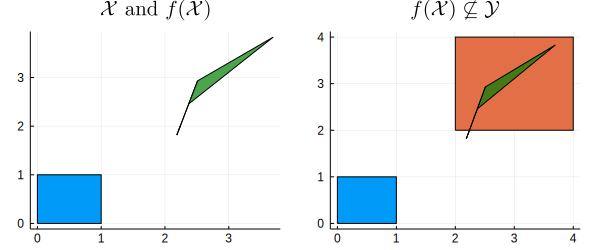

In [72]:
p1 = plot(X, title = L"\mathcal{X}\mathrm{\ and\ }f(\mathcal{X})")
plot!(p1, res.reachable, line = (1, :black), fill = (0.7, :green))

p2 = plot(X, title = L"f(\mathcal{X}) \not\subseteq \mathcal{Y}")
plot!(p2, Y)
plot!(p2, res.reachable, fill = (0.7, :green))

plot(p1, p2, size = (600, 250))

### MaxSens

We see that the desired output set does not contain the true output set, which is the definition of a violated property. However, we took a computationally expensive approach to reach this conclusion, as mentioned earlier. We have other reachability (and non-reachability) algorithms at our disposal as well, which trade off over-approximation with computational efficiency. Next, we will try the same thing again using the `MaxSens` algorithm, which first partitions the set into hyperrectangles at a specified resolution, and then propagates each of those through the network in a fast but approximate way. We can solve the problem with a number of different resolutions to observe the effect on accuracy.

In [89]:
maxsens_results = [solve(MaxSens(resolution = r), prob) for r in reverse(0.1:0.1:0.9)];

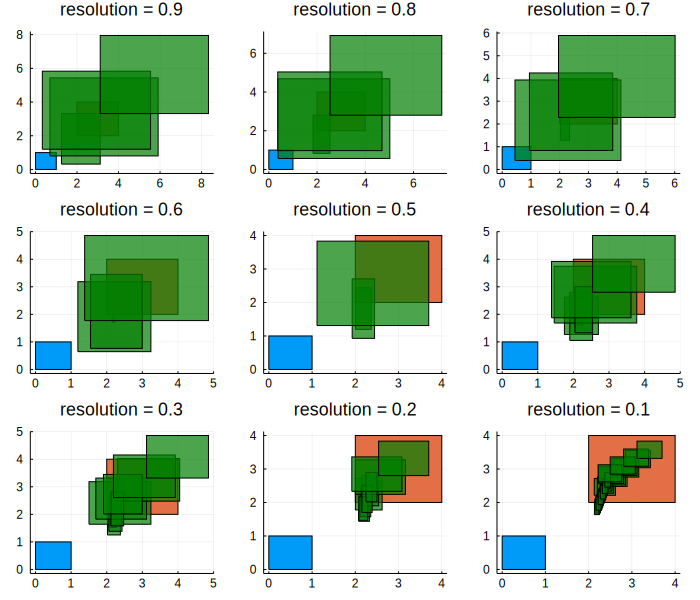

In [90]:
p = []

p1 = plot(X)
for i in 1:length(maxsens_results)
    p2 = deepcopy(p1)
    plot!(p2, Y)
    plot!(p2, maxsens_results[i].reachable, line = (1, :black), 
          fill = (0.7, :green), titlefontsize = 12, 
          title = "resolution = $(round(1.0 - 0.1*i, digits = 2))")
    push!(p, p2)
end

plot(p..., size = (700,600))